# EMOTION ANALYSIS

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[vision,notebook]"
%pip install --quiet facenet_pytorch
import evadb
cursor = evadb.connect().cursor()

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


### Download Video

In [2]:
# A video of a happy person
!wget -nc "https://www.dropbox.com/s/gzfhwmib7u804zy/defhappy.mp4?raw=1" -O defhappy.mp4

# Adding Emotion detection
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/udfs/emotion_detector.py

# Adding Face Detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/udfs/face_detector.py

File ‘defhappy.mp4’ already there; not retrieving.


File ‘emotion_detector.py’ already there; not retrieving.



File ‘face_detector.py’ already there; not retrieving.



### Load video for analysis

In [3]:
response = cursor.query("DROP TABLE IF EXISTS HAPPY;").df()
print(response)
cursor.load(file_regex="defhappy.mp4", table_name="HAPPY", format="VIDEO").df()

                                   0
0  Table Successfully dropped: HAPPY


,0
0,Number of loaded VIDEO: 1


### Create a function for analyzing the frames

In [4]:
cursor.query("""CREATE UDF IF NOT EXISTS EmotionDetector 
        INPUT (frame NDARRAY UINT8(3, ANYDIM, ANYDIM)) 
        OUTPUT (labels NDARRAY STR(ANYDIM), scores NDARRAY FLOAT32(ANYDIM)) 
        TYPE  Classification IMPL 'emotion_detector.py';
        """).df()

cursor.query("""CREATE UDF IF NOT EXISTS FaceDetector
                  INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
                  OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
                          scores NDARRAY FLOAT32(ANYDIM))
                  TYPE  FaceDetection
                  IMPL  'face_detector.py';
        """).df()

,0
0,"UDF FaceDetector already exists, nothing added."


### Run the Face Detection UDF on video 

In [5]:
query = cursor.table("HAPPY")
query = query.filter("id < 10")
query = query.select("id, FaceDetector(data)")

query.df()

2023-06-17 00:34:35,684	INFO worker.py:1625 -- Started a local Ray instance.


,happy.id,facedetector.bboxes,facedetector.scores
0,0,"[[502, 94, 762, 435], [238, 296, 325, 398]]","[0.99990165, 0.79820246]"
1,1,"[[501, 96, 763, 435]]",[0.999918]
2,2,"[[504, 97, 766, 437]]",[0.9999138]
3,3,"[[498, 90, 776, 446]]",[0.99996686]
4,4,"[[496, 99, 767, 444]]",[0.9999982]
5,5,"[[499, 87, 777, 448], [236, 305, 324, 407]]","[0.9999136, 0.8369736]"
6,6,"[[500, 89, 778, 449]]",[0.9999131]
7,7,"[[501, 89, 781, 452]]",[0.9999124]
8,8,"[[503, 90, 783, 450]]",[0.99994683]
9,9,"[[508, 87, 786, 447]]",[0.999949]


### Run the Emotion Detection UDF on the outputs of the Face Detection UDF

In [6]:
query = cursor.table("HAPPY")
query = query.cross_apply("UNNEST(FaceDetector(data))", "Face(bbox, conf)")
query = query.filter("id < 15")
query = query.select("id, bbox, EmotionDetector(Crop(data, bbox))")

response = query.df()

In [7]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['Face.bbox', 'emotiondetector.labels', 'emotiondetector.scores']][df.index == frame_id]
        if df.size:
            
            x1, y1, x2, y2 = df['Face.bbox'].values[0]
            label = df['emotiondetector.labels'].values[0]
            score = df['emotiondetector.scores'].values[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # object bbox
            frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
            # object label
            cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # object score
            cv2.putText(frame, str(round(score, 5)), (x1+120, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # frame label
            cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
        
            video.write(frame)
            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()
        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

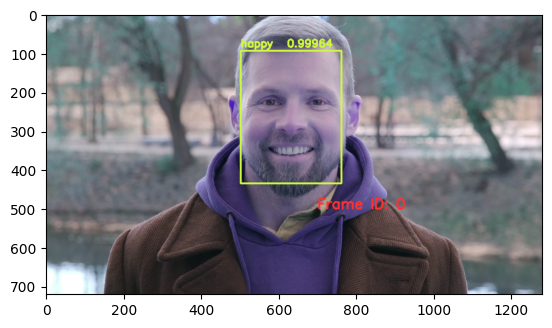

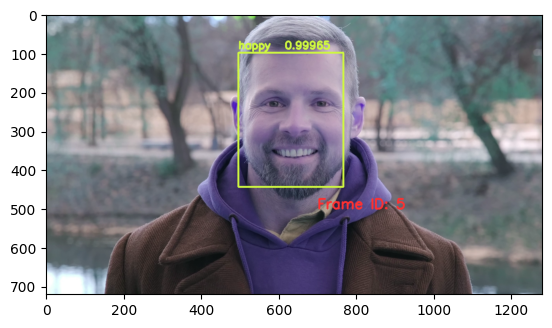

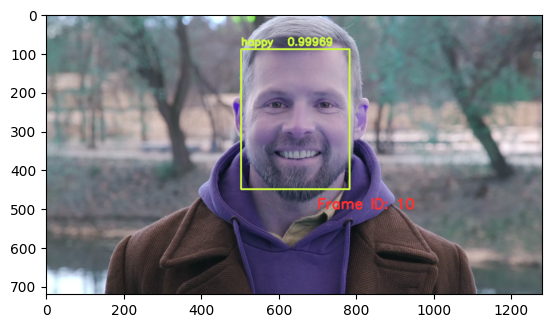

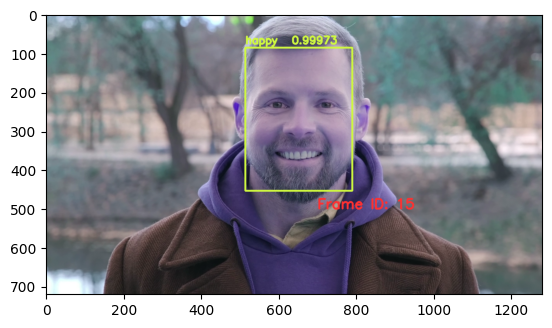

In [8]:
from ipywidgets import Video, Image
input_path = 'defhappy.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)

### Dropping an User-Defined Function (UDF)

In [9]:
#cursor.drop(item_name="EmotionDetector", item_type="UDF").df()
#cursor.drop(item_name="FaceDetector", item_type="UDF").df()